In [43]:
from module import toSunpyMap, getMostRecent, flatten
import sunpy

import matplotlib.pyplot as plt

In [44]:
directory = 'Z:/data/CLIMSO/2024/data_calibrated'

file = getMostRecent(directory, '_c1_')


map=toSunpyMap(file, center_disk=False)

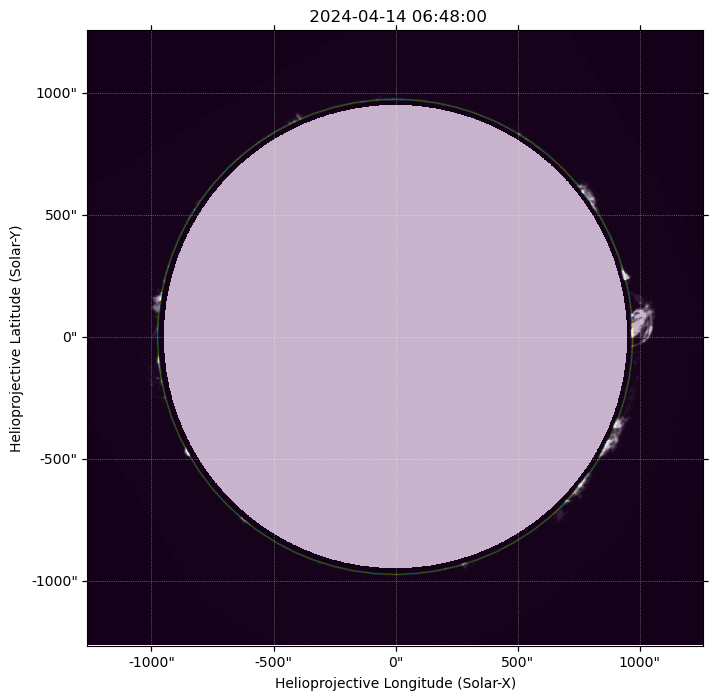

In [45]:
import cv2 as cv
import numpy as np

image=np.zeros(map.data.shape)
cv.circle(image, (1024,1024), int(map.meta['rsun_obs'])+0, (255,255,255), 3)

mask = np.zeros(map.data.shape, dtype=np.uint8)
cv.circle(mask, (int(map.meta['crpix1']), int(map.meta['crpix2'])), int(map.meta['rsun_obs'])-20, 1, thickness=-1)

data=np.array(map.data).astype(np.float64)
data[mask==1]=np.nan

map = sunpy.map.Map(data, map.meta)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=map)
map.plot()
plt.imshow(image, alpha=0.3);

In [46]:
map.meta['rsun_obs'] = int(map.meta['rsun_obs'])+0

In [47]:
from sunpy.map.header_helper import make_heliographic_header

carr_header = make_heliographic_header(map.date, map.observer_coordinate, map.data.shape, frame='carrington')

outmap = map.reproject_to(carr_header)

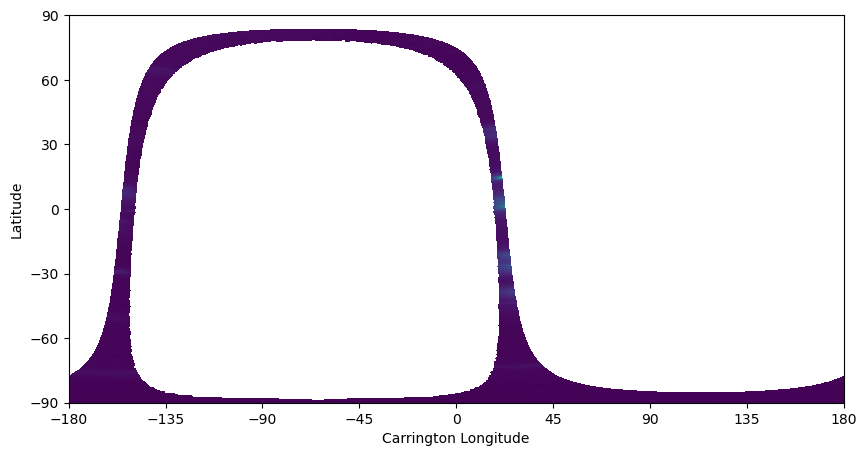

In [48]:
fig = plt.figure(figsize=(10,10))
plt.imshow(outmap.data,origin='lower', extent=[-180,180,-90,90]);

plt.xticks(np.arange(-180, 181, 45))
plt.yticks(np.arange(-90, 91, 30))

plt.axis()

plt.xlabel('Carrington Longitude');
plt.ylabel('Latitude');

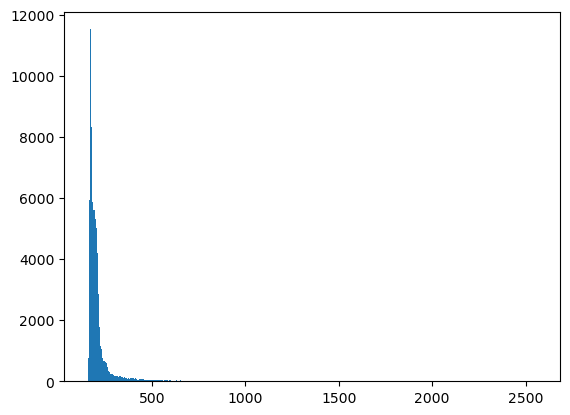

In [49]:
plt.hist(outmap.data.flatten(), bins='auto');